In [117]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [140]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False
df=pd.read_csv('final_dataset_csv.csv', sep=',',header=0)
test_data_size = (int(df.shape[0] * 0.20))
df.drop(df.tail(test_data_size).index, inplace = True) # remove and set aside 20% of dataset for testing.

TRAIN_SPLIT = int(df.shape[0]*0.80) # 80% training 20 % validation
# they definitely needs optimization.
BATCH_SIZE = 32 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10 # for shuffling the dataset
STEP = 1 # for creation of dataset

# Train and evaluate
STEPS_PER_EPOCH = 10 # hyperparameter
EPOCHS = 10 # hyperparameter

In [119]:
# x = df.drop('RES_LEVEL_FT', axis=1)
# y = df['RES_LEVEL_FT']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle = False)
# x.columns

<AxesSubplot:xlabel='FLOW_DATE'>

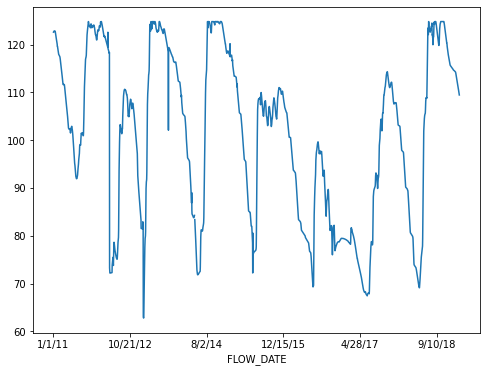

In [141]:
# univariate data
uni_data_df = df['RES_LEVEL_FT']
uni_data_df.index = df['FLOW_DATE']
uni_data_df.head()
uni_data_df.plot()

In [142]:
df.head()
df.columns
df[['OUTFLOW_CUECS']]
features = df[['PRESENT_STORAGE_TMC', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'tempC', 'windspeedKmph', 'precipMM', 'humidity', 'pressure (mB)', 'cloudcover (%)', 'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph', 'RES_LEVEL_FT']]
features.index = df['FLOW_DATE']
features.head()

,PRESENT_STORAGE_TMC,INFLOW_CUSECS,OUTFLOW_CUECS,tempC,windspeedKmph,precipMM,humidity,pressure (mB),cloudcover (%),HeatIndexC,DewPointC,WindChillC,WindGustKmph,RES_LEVEL_FT
FLOW_DATE,,,,,,,,,,,,,,
1/1/11,46.42,2029.0,2000,28,6,0.3,74,1010,45,23,17,22,10,122.59
1/2/11,46.54,3084.0,1490,28,7,0.3,72,1010,27,23,16,22,12,122.68
1/3/11,46.64,2776.0,1491,26,11,0.4,76,1011,46,22,16,21,16,122.75
1/4/11,46.69,2311.0,1491,26,12,0.4,80,1012,61,21,17,21,16,122.79
1/5/11,46.70,1847.0,1491,26,10,3.2,81,1011,73,22,17,21,14,122.80


array([<AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>,
       <AxesSubplot:xlabel='FLOW_DATE'>, <AxesSubplot:xlabel='FLOW_DATE'>],
      dtype=object)

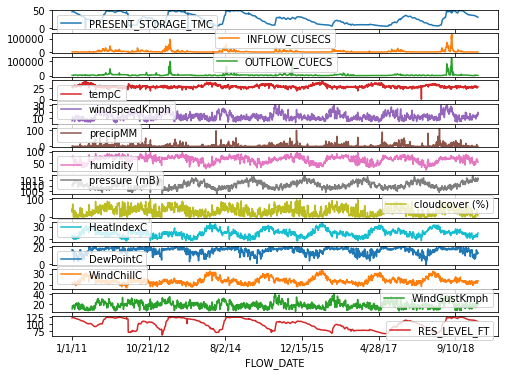

In [143]:
features.plot(subplots = True)

In [144]:
# standardize the data
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis = 0)
# data_mean
# data_std.shape
# dataset = (dataset-data_mean)/data_std
# dataset.shape


In [145]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [146]:
future_target = 90 # 90 future values
past_history = 450
print (dataset[:,13]) # water res levels needs to be predicted
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 13], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 13],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)


[122.59 122.68 122.75 ... 109.84 109.62 109.45]
(1404, 450, 14)
(1404, 90)
(255, 450, 14)
(255, 90)


In [147]:


# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()



In [148]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


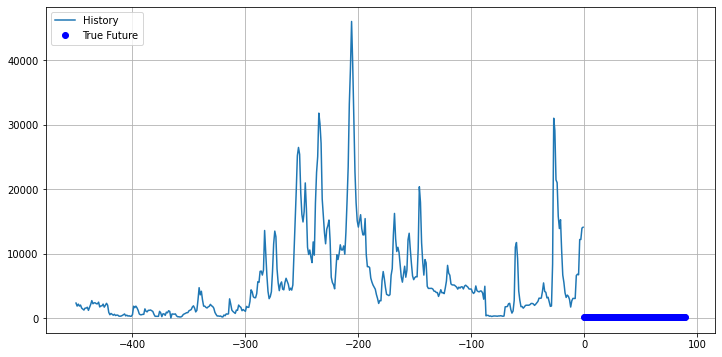

2021-07-17 21:11:57.172176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [149]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [150]:
print (x_train_multi.shape[-2:])
print (x_train_multi.shape)
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(16,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(90)) # for 90 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

(450, 14)
(1404, 450, 14)
Epoch 1/10
10/10 [==============================] - 5s 537ms/step - loss: 108.1566 - val_loss: 103.4246
Epoch 2/10
10/10 [==============================] - 5s 479ms/step - loss: nan - val_loss: nan
Epoch 3/10
10/10 [==============================] - 6s 553ms/step - loss: nan - val_loss: nan
Epoch 4/10
10/10 [==============================] - 5s 457ms/step - loss: nan - val_loss: nan
Epoch 5/10
10/10 [==============================] - 5s 450ms/step - loss: nan - val_loss: nan
Epoch 6/10
10/10 [==============================] - 5s 454ms/step - loss: nan - val_loss: nan
Epoch 7/10
10/10 [==============================] - 5s 480ms/step - loss: nan - val_loss: nan
Epoch 8/10
10/10 [==============================] - 6s 612ms/step - loss: nan - val_loss: nan
Epoch 9/10
10/10 [==============================] - 5s 452ms/step - loss: nan - val_loss: nan
Epoch 10/10
10/10 [==============================] - 4s 443ms/step - loss: nan - val_loss: nan


In [151]:


# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()

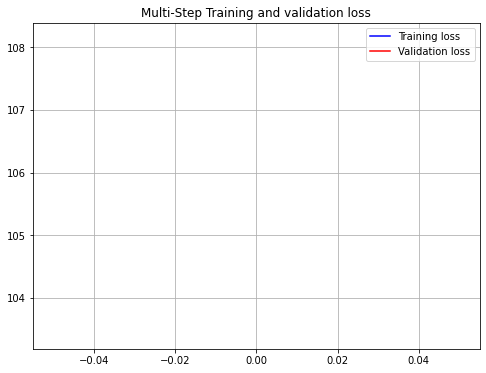

In [152]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

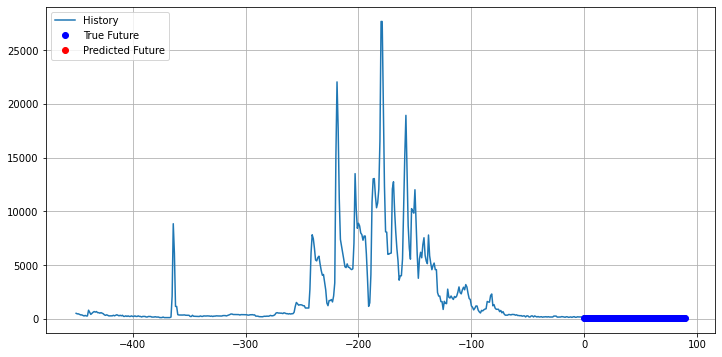

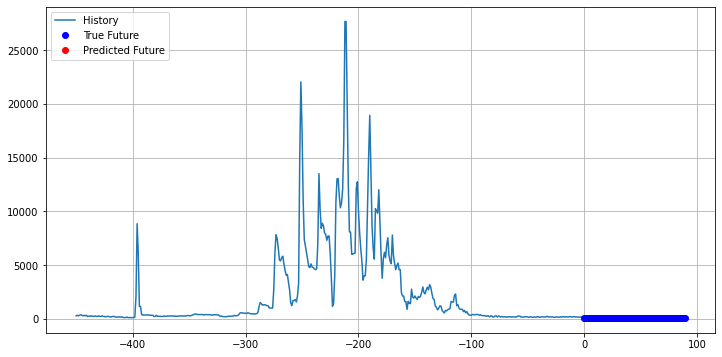

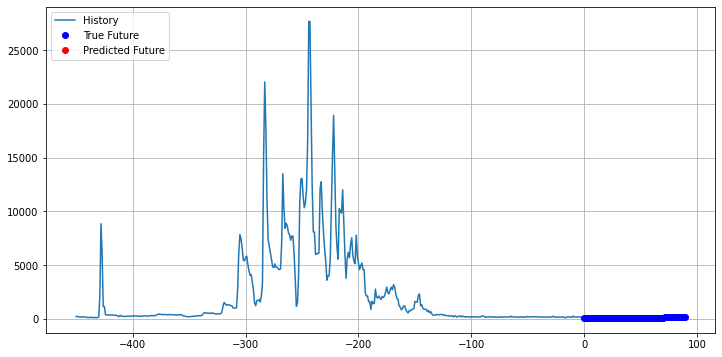

In [153]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])